<a href="https://colab.research.google.com/github/VinhDevNguyen/Machine-Learning/blob/master/Project/Hand_crafted_features_for_GTZAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [25]:
np.random.seed(42)

In [26]:
gtzan_dir = '/content/drive/My Drive/genres/'

# Parameters
song_samples = 22050*30
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [27]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}

    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [28]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr)
                features['genre'] = genres[x]
                arr_features.append(features)
    return arr_features

In [ ]:
%%time

# Get list of dicts with features and convert to dataframe
features = read_process_songs(gtzan_dir, debug=True)

In [31]:
df_features = pd.DataFrame(features)

In [32]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,roloff_kurtosis,roloff_skew,flux_max,flux_min,flux_mean,flux_std,flux_kurtosis,flux_skew,rmse_max,rmse_min,rmse_mean,rmse_std,rmse_kurtosis,rmse_skew,zcr_max,zcr_min,zcr_mean,zcr_std,zcr_kurtosis,zcr_skew,contrast_max,contrast_min,contrast_mean,contrast_std,contrast_kurtosis,contrast_skew,bandwidth_max,bandwidth_min,bandwidth_mean,bandwidth_std,...,mfcc_6_kurtosis,mfcc_6_skew,mfcc_7_max,mfcc_7_min,mfcc_7_mean,mfcc_7_std,mfcc_7_kurtosis,mfcc_7_skew,mfcc_8_max,mfcc_8_min,mfcc_8_mean,mfcc_8_std,mfcc_8_kurtosis,mfcc_8_skew,mfcc_9_max,mfcc_9_min,mfcc_9_mean,mfcc_9_std,mfcc_9_kurtosis,mfcc_9_skew,mfcc_10_max,mfcc_10_min,mfcc_10_mean,mfcc_10_std,mfcc_10_kurtosis,mfcc_10_skew,mfcc_11_max,mfcc_11_min,mfcc_11_mean,mfcc_11_std,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,5514.393296,1789.366583,3176.995746,550.485825,1.277930,0.851571,9905.273438,4005.175781,6235.702536,1316.782580,-0.180793,0.740059,4.741454,0.0,1.131944,0.640262,4.268698,1.844055,0.190168,0.069933,0.115640,0.020419,0.336553,0.741844,0.434570,0.034180,0.183035,0.053053,0.427356,0.210292,49.744175,5.486981,18.553157,7.368565,4.498751,2.095908,3944.153147,1920.270253,2689.861255,396.315906,...,-0.159542,0.041186,35.826104,-16.580031,9.600043,8.646835,-0.254599,0.079988,29.095461,-24.260442,4.991134,8.425138,-0.173886,-0.020526,33.727515,-15.221754,7.408411,7.851482,-0.123271,-0.015742,20.184411,-27.564287,-5.106789,8.432188,-0.159462,0.132810,35.844667,-13.084319,10.570468,8.282726,-0.381802,-0.087361,20.820357,-32.647716,-4.103276,8.186303,0.171622,-0.170111,95.703125,0
1,5626.545444,1763.465470,2850.163030,450.508356,7.136744,1.872261,10314.404297,4155.908203,5926.993343,852.511470,3.561296,1.291193,5.554421,0.0,1.104693,0.689680,6.209002,2.247360,0.152074,0.051751,0.096879,0.017282,-0.547248,0.180199,0.477539,0.041016,0.152820,0.046267,5.195550,1.238239,53.176154,6.074287,20.087125,9.656356,1.593964,1.680137,3810.083843,1909.645309,2603.779274,230.726219,...,-0.319718,-0.000310,49.229847,-5.388819,22.603444,8.206173,0.098735,-0.173855,17.891310,-33.645117,-7.659279,8.026306,-0.184663,0.134945,40.008255,-12.828545,11.584114,8.350451,-0.022319,0.220047,19.186692,-28.501605,-4.416517,7.467792,0.174989,0.081190,35.808877,-12.607810,11.399026,7.171574,-0.122148,0.049450,19.133056,-32.525145,-10.894270,7.584343,0.193536,0.236081,151.999081,0
2,4136.766528,1406.764645,2394.445992,449.865790,1.572860,0.983919,7795.019531,3359.179688,4868.069352,889.308788,1.146075,1.158830,6.579998,0.0,1.169997,1.002798,6.183047,2.348479,0.299507,0.048391,0.119991,0.041596,3.168297,1.762958,0.298828,0.032227,0.134291,0.041058,0.787905,0.636778,48.795467,5.702659,20.233934,9.146455,1.379734,1.603487,3188.368723,1619.322699,2188.617083,285.094516,...,-0.256658,0.156553,39.010441,-23.887159,12.785773,9.287199,0.177914,-0.308665,11.752551,-44.397171,-16.699161,9.041607,-0.131615,0.105221,47.820315,-13.675356,16.104855,9.175206,0.007458,-0.054710,17.508290,-30.910432,-9.346024,8.350279,-0.316460,0.146060,39.093799,-18.864042,8.355241,8.002787,0.040864,-0.056040,9.942626,-39.236105,-15.879491,6.665164,0.421181,-0.004789,151.999081,0
3,4141.859853,1554.571724,2700.584556,411.301524,-0.256259,0.124371,7708.886719,3531.445312,5178.110839,679.032203,-0.233782,0.240711,5.117185,0.0,1.165081,0.663197,4.641896,1.818542,0.251725,0.071401,0.148695,0.035954,-0.605695,0.302373,0.375977,0.034180,0.166672,0.053765,0.094853,0.183645,52.638593,4.912222,20.284350,10.153702,1.424152,1.663383,2968.144709,1661.334319,2203.400173,177.350188,...,0.200186,0.248762,56.894018,-1.252997,28.285302,9.183560,0.139424,-0.364696,11.697977,-42.035911,-14.347446,7.767630,0.340239,0.409840,49.875460,-2.348236,21.852601,6.977073,0.409377,0.316633,24.505113,-27.894919,-7.229421,7.860917,0.070731,0.327007,38.098999,-6.398772,15.6

In [33]:
df_features.to_csv('/content/drive/My Drive/gtzan_features.csv', index=False)

In [36]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values


In [38]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 3.63006262e-01,  2.44018061e+00,  1.54407713e+00,
        -3.60376762e-01, -2.32241737e-01, -1.51871311e-01,
         9.94779673e-01,  2.56777441e+00,  1.20947400e+00,
        -1.66837154e-02, -2.66165753e-01,  4.40039468e-01,
        -1.40342957e+00,  0.00000000e+00, -8.37635752e-01,
        -1.35035072e+00, -5.47161343e-01, -9.82859123e-01,
        -8.57377332e-01,  1.67696080e+00, -2.03559981e-01,
        -1.12318680e+00, -1.68716020e-01,  1.67704183e-01,
         1.70951821e-01,  1.38702445e+00,  1.90055825e+00,
        -5.88504432e-02, -6.87194444e-01, -1.26269615e+00,
        -1.37583188e-01,  4.20864499e-01, -9.04024368e-01,
         2.83213981e-01,  3.51753875e+00,  2.47540264e+00,
         9.84360687e-01,  1.59650203e+00,  9.54080642e-01,
         2.10571036e-01, -3.19879920e-01,  3.35341345e-01,
         8.80345974e-01,  8.99546038e-01,  1.50889336e+00,
         1.13409992e+00, -4.53225870e-01, -8.07194467e-01,
        -4.37775203e-02, -4.37775203e-02, -4.37775203e-0

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (800, 133) (800,)
Test set: (200, 133) (200,)


# Support Vector Machine

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.svm import SVC

svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train, y_train)

param_distributions = {"gamma": reciprocal(0.001, 1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train, y_train)

rnd_search_cv.best_estimator_
rnd_search_cv.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=8.965429868602328, gamma=0.0035506214270707693 ................
[CV] . C=8.965429868602328, gamma=0.0035506214270707693, total=   0.1s
[CV] C=8.965429868602328, gamma=0.0035506214270707693 ................
[CV] . C=8.965429868602328, gamma=0.0035506214270707693, total=   0.1s
[CV] C=8.965429868602328, gamma=0.0035506214270707693 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] . C=8.965429868602328, gamma=0.0035506214270707693, total=   0.1s
[CV] C=8.796910002727692, gamma=0.06173770394704572 ..................
[CV] ... C=8.796910002727692, gamma=0.06173770394704572, total=   0.1s
[CV] C=8.796910002727692, gamma=0.06173770394704572 ..................
[CV] ... C=8.796910002727692, gamma=0.06173770394704572, total=   0.1s
[CV] C=8.796910002727692, gamma=0.06173770394704572 ..................
[CV] ... C=8.796910002727692, gamma=0.06173770394704572, total=   0.1s
[CV] C=5.458327528535912, gamma=0.0019949166150633932 ................
[CV] . C=5.458327528535912, gamma=0.0019949166150633932, total=   0.1s
[CV] C=5.458327528535912, gamma=0.0019949166150633932 ................
[CV] . C=5.458327528535912, gamma=0.0019949166150633932, total=   0.1s
[CV] C=5.458327528535912, gamma=0.0019949166150633932 ................
[CV] . C=5.458327528535912, gamma=0.0019949166150633932, total=   0.1s
[CV] C=5.592488919658671, gamma=0.010025956902289565 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.4s finished


0.772488336947237

In [42]:
rnd_search_cv.best_estimator_.fit(X_train, y_train)

SVC(C=8.965429868602328, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0035506214270707693, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_hat = rnd_search_cv.best_estimator_.predict(X_train)
accuracy_score(y_train, y_hat)

0.99375

In [45]:
y_hat = rnd_search_cv.best_estimator_.predict(X_test)
accuracy_score(y_test, y_hat)

0.745

              precision    recall  f1-score   support

           0       0.70      0.84      0.76        19
           1       0.61      0.67      0.64        21
           2       0.91      0.87      0.89        23
           3       0.74      0.74      0.74        19
           4       0.80      0.89      0.84        18
           5       0.79      0.68      0.73        22
           6       0.76      0.89      0.82        18
           7       0.90      0.79      0.84        24
           8       0.69      0.56      0.62        16
           9       0.53      0.50      0.51        20

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200

Confusion matrix, without normalization
[[16  1  0  1  0  0  0  0  0  1]
 [ 0 14  0  1  0  1  1  1  1  2]
 [ 0  0 20  0  3  0  0  0  0  0]
 [ 0  2  0 14  0  0  0  0  3  0]
 [ 0  0  2  0 16  0  0  0  0  0]
 [ 0  1  0  0  1 15  1  0  0  4]
 [ 

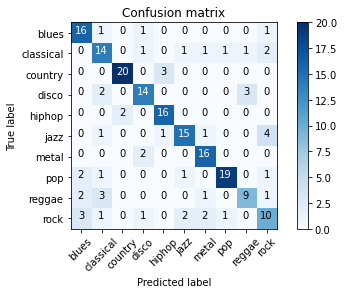

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)

print (classification_report(y_test, y_hat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],normalize= False,  title='Confusion matrix')

# K-Neighbor

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# Find the best K
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.69, 0.67, 0.65, 0.69, 0.68, 0.65, 0.65, 0.65, 0.67, 0.65, 0.66,
       0.65, 0.62, 0.62, 0.62, 0.62, 0.62, 0.64, 0.62, 0.64, 0.62, 0.61,
       0.6 , 0.58, 0.57, 0.56, 0.57, 0.57, 0.57, 0.58, 0.57, 0.57, 0.56,
       0.56, 0.56, 0.54, 0.54, 0.53, 0.53, 0.54, 0.52, 0.53, 0.53, 0.53,
       0.53, 0.53, 0.52, 0.54, 0.53, 0.52, 0.52, 0.53, 0.52, 0.51, 0.49,
       0.5 , 0.49, 0.49, 0.48, 0.47, 0.48, 0.48, 0.49, 0.48, 0.48, 0.48,
       0.49, 0.49, 0.49, 0.48, 0.48, 0.49, 0.48, 0.47, 0.48, 0.48, 0.48,
       0.47, 0.47, 0.47, 0.47, 0.46, 0.46, 0.46, 0.45, 0.45, 0.47, 0.47,
       0.47, 0.47, 0.47, 0.46, 0.46, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47])

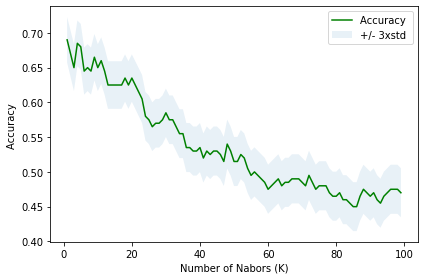

In [50]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [51]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.69 with k= 1
